# Quantifying swamp forest extent changes and wetland Greenhouse Gas (GHG) emissions in the Congo basin

Processes PALSAR imagery and ancilliary datasets from Google Earth Engine (GEE) to classify swamp forest extents, forest productivity, water table levels and GHG emissions in the Congo basin from 2007 to 2025. External data required to run the script can be downloaded from here*

Requirements:
1. Google drive access
2. Google earth engine access
3. 2 X Google Earth Engine Image Collection asset folders

Inputs:
1.   GEE data (PALSAR, MODIS EVI, MERIT Hydro, Forest cover)
2.   Groundtruth coordinates for classification (requires download)*
3.   GHG fluxes by water table level (requires download)*

Outputs:
1. Annual swamp forest extents in the Congo Basin
2. Annual EVI values for swamp forests, dry forests and all forests
3. Annual wetland fluxes of CO2, CH4 and N2O

Author: aidan.byrne@ioz.ac.uk

Script created on 12/03/2025. Last modified 03/06/2025

# Load packages

In [ ]:
!pip install scikit-posthocs
!pip install rasterio

In [3]:
import ee
from google.colab import drive
import math
import numpy as np
import pandas as pd
import geemap
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import os
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import ttest_rel, wilcoxon
from scipy.stats import linregress, t

# Load GEE and mount drive

In [4]:
### Connect to Google Earth Engine

# Trigger the authentication flow
ee.Authenticate()

# Initialize the library - your cloud username
ee.Initialize(project="ee-aidanbyrne")

In [5]:
### Connect to google drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Load data

In [6]:
### Define study area, datasets, and static layers

# Get the Congo basin geometry from the HydroSHEDS collection
basin = (ee.FeatureCollection('WWF/HydroSHEDS/v1/Basins/hybas_3')
         .filter(ee.Filter.eq('HYBAS_ID', 1030020040))).first().geometry()

basinSimple = basin.simplify(500) # smooths polygon vertices to reduce processing time when exporting data

# select subbasins
basinfilter = basin.buffer(-100)

subbasins = (ee.FeatureCollection('WWF/HydroSHEDS/v1/Basins/hybas_4')
             .filterBounds(basinfilter))

# DEM
meritDEM = ee.Image("MERIT/DEM/v1_0_3").clip(basin)

# Height Above Nearest Drainage (HAND)
HAND = ee.Image('MERIT/Hydro/v1_0_1').clip(basin)

# Forest layer
forest = ee.ImageCollection('UMD/GLAD/PRIMARY_HUMID_TROPICAL_FORESTS/v1').mosaic().selfMask().clip(basin) # new data with better map
forest = forest.select("Primary_HT_forests").rename("Map")
forestBinary = forest.select('Map').eq(1) # for spatial trends
forestMap = forestBinary.selfMask().unmask(0).clip(basin) # for spatial trends

# Rivers
rivers = ee.Image('MERIT/Hydro/v1_0_1').select('wat').eq(1).clip(basin)
rivers = rivers.updateMask(rivers.gte(0.4))
riversMask = rivers.unmask(0).clip(basin)
openwater = ee.ImageCollection("GLCF/GLS_WATER").mosaic().select('water').eq(2).clip(basin)

# PALSAR-2
PALSARCollection = (ee.ImageCollection('JAXA/ALOS/PALSAR-2/Level2_2/ScanSAR')
                     .filterBounds(basin)
                     .filter(ee.Filter.eq('PassDirection', 'Descending')))
# PALSAR-1
PALSARCollectionannual = (ee.ImageCollection('JAXA/ALOS/PALSAR/YEARLY/SAR_EPOCH'))
                     #.filterBounds(basin)
                     #.filter(ee.Filter.eq('PassDirection', 'Descending')))

# MODIS EVI
modis = ee.ImageCollection('MODIS/061/MOD13A3')

# Define parameters

In [27]:
# Define the destination to export PALSAR classification and EVI images - your GEE image collection asset - you must create this in GEE first and ensure the names match the following paths
asset_path_PALSAR = 'projects/ee-aidanbyrne/assets/YOUR_PALSAR_IMAGE_COLLECTION/'# change to your path - must end with /
asset_path_EVI = 'projects/ee-aidanbyrne/assets/YOUR_EVI_IMAGE_COLLECTION/' # change to your path

# Classification image date
startDateImage = ee.Date('2019-01-01')
endDateImage = ee.Date('2020-01-01')

# study period for timeseries
startDate = ee.Date('2007-01-01')
endDate = ee.Date('2025-01-01')

# study period for timeseries - PALSAR-1
startDatePalsar1 = ee.Date('2007-01-01')
endDatePalsar1 = ee.Date('2011-01-01')

# study period for timeseries - PALSAR-2
startDatePalsar2 = ee.Date('2015-01-01')
endDatePalsar2 = ee.Date('2025-01-01')

# Spatial scale for exporting area and EVI calculations (reduce region function)
spatialScale = 90 # to match classifications with HAND resolution for flood depths and WTLs
tileScale = 2 # to split calculations over subsections when exporting - avoids exceeding memory usage

# Define functions

## Preprocess GEE data

In [8]:
#######################
###### PALSAR-2 #######
#######################

def applyBitmaskPalsar2(image):
    msk = image.select('MSK')
    quality = msk.bitwiseAnd(7)  # extract bits 0-2
    validMask = quality.eq(1)
    return image.updateMask(validMask)

def preprocessPalsarPalsar2(image):
    """Convert DN to backscatter in dB for PALSAR image."""
    hh = image.select('HH').pow(2).log10().multiply(10).add(-83.0)
    hv = image.select('HV').pow(2).log10().multiply(10).add(-83.0)
    lin = image.select('LIN').multiply(0.01)
    filtered = hh.addBands(hv).addBands(lin)
    return filtered

def correctIncidenceAnglePalsar2(image):
    localAngle = image.select('LIN').multiply(math.pi / 180)
    refAngle = ee.Image.constant(37).multiply(math.pi / 180)
    hhLinear = ee.Image(10).pow(image.select('HH').divide(10.0))
    hvLinear = ee.Image(10).pow(image.select('HV').divide(10.0))
    hhCorrected = hhLinear.multiply(refAngle.cos()).divide(localAngle.cos()).rename('HH_corrected')
    hvCorrected = hvLinear.multiply(refAngle.cos()).divide(localAngle.cos()).rename('HV_corrected')
    hhCorrectedDb = hhCorrected.log10().multiply(10).rename('HH_corrected_db')
    hvCorrectedDb = hvCorrected.log10().multiply(10).rename('HV_corrected_db')
    return image.addBands(hhCorrectedDb).addBands(hvCorrectedDb)

def leeFilter(image):
    kernel = ee.Kernel.square(radius=1, units='pixels', normalize=False)
    # Compute the local mean and variance using the 3x3 kernel
    localMean = image.reduceNeighborhood(reducer=ee.Reducer.mean(), kernel=kernel)
    localVariance = image.reduceNeighborhood(reducer=ee.Reducer.variance(), kernel=kernel)
    # Compute the weight for each pixel
    weight = localVariance.subtract(localMean).divide(localVariance).max(0)
    # Apply the filter to all bands using the calculated weight
    filtered = localMean.add(weight.multiply(image.subtract(localMean)))
    # Ensure that the band names remain unchanged
    filtered = filtered.rename(image.bandNames())
    return filtered

# apply speckle filter (3x3) to classification layer to remove isolated pixels for further WTLs analyses
def kernelFilter(image):
  square_kernel = ee.Kernel.square(radius=1, units='pixels') #radius 1 for 3x3 kernel, 2 for 5x5 kernel, 4 for figures smoother
  classification = image.select("flooded_classification") \
                  .focal_mode(kernel=square_kernel, iterations=1).rename("flooded_classification_kernel")
  return image.addBands(classification)

######################
##### Palsar 1 #######
######################

def applyBitmaskPalsar1(image):
    """Apply QA band mask to remove bad data (No data, Layover, Shadowing)."""
    # Select the QA band
    qa = image.select('qa')
    # Create a mask where QA values are not in [0, 100, 150]
    mask = qa.neq(0).And(qa.neq(100)).And(qa.neq(150))
    return image.updateMask(mask)

### for gap filling 2008 image
def createNoDataMaskPalsar1(image):
    """Create a binary image where 1 = No data (qa == 0), 0 = Data pixels."""
    # Select the QA band
    qa = image.select('qa')
    # Create a binary mask: 1 where qa == 0 (No data), 0 otherwise
    no_data_mask = qa.eq(0).rename('no_data_mask')
    return no_data_mask

def preprocessPalsarPalsar1(image):
    """Preprocess PALSAR HH and HV bands to dB and retain incidence angle."""
    # Convert HH and HV bands to dB scale
    hh = image.select('HH').pow(2).log10().multiply(10).add(-83.0)
    hv = image.select('HV').pow(2).log10().multiply(10).add(-83.0)
    # Select incidence angle (no modification needed here)
    lin = image.select('angle')
    # Remove the original HH and HV bands and add the processed ones
    processed = image.select(['angle']) \
                     .addBands(hh.rename('HH')) \
                     .addBands(hv.rename('HV'))  # Retain 'angle' and replace 'HH' and 'HV' bands
    # Return the processed image with replaced HH and HV bands
    return processed

# Fill data gaps in 2008 annual image using 2007 image
def Fill_data_gaps_PALSAR1(image):
    # Compare the image ID to that of the 2008 image
    cond = ee.String(image.id()).equals(ee.String(PALSARimage2008.id()))
    # Use ee.Algorithms.If to choose between the updated image and the original image
    return ee.Image(ee.Algorithms.If(cond, PALSARimage2008Updated, image))

def maskModisQA(image):
    qa = image.select('SummaryQA')
    # Create a mask: True where QA equals 0, False elsewhere.
    mask = qa.lte(1)
    # Update the image mask; only good pixels will be kept.
    return image.updateMask(mask)

def processEVI(image):
    return image.select('EVI').multiply(0.0001) # apply scaling factor

## Preprocess groundtruth data

In [9]:
######################################
#### ground truth data processing ####
######################################

def df_to_ee_feature_collection(df):
    # Create a list to store features
    features = []
    # Iterate through each row in the dataframe
    for index, row in df.iterrows():
        # Create a point geometry using lat and lon
        point = ee.Geometry.Point([float(row['Lon']), float(row['Lat'])])
        # Create properties dictionary with Landcover_classification
        properties = {
            'Landcover_classification': row['Landcover_classification']
        }
        # Create feature with geometry and properties
        feature = ee.Feature(point, properties)
        features.append(feature)
    return ee.FeatureCollection(features)

# Map string labels to numerical values for classification
def add_class_property(feature):
    class_value = feature.getString('Landcover_classification')
    class_num = ee.Algorithms.If(class_value.equals('Peat swamp forest'), 1, 0)
    return feature.set('class', class_num)

## Classify swamp forests

In [10]:
######################################
#### classify swamp forest extent ####
######################################

### palsar 2

def getFloodedImage(interval):
    """For a given interval dictionary, return a image with classified swamp forest pixels"""
    interval = ee.Dictionary(interval)
    s = ee.Date(interval.get('start'))
    e = ee.Date(interval.get('end'))
    # Filter PALSAR images for the given time interval and process
    palsarInterval = PALSARCollection.filterDate(s, e)
    processedPalsar = (palsarInterval
                       .map(applyBitmaskPalsar2)
                       .map(leeFilter)
                       .map(preprocessPalsarPalsar2)
                       .map(correctIncidenceAnglePalsar2))
    palsarImage = processedPalsar.median().clip(basin)
    # Create the HV/HH ratio band.
    ratio = palsarImage.addBands(
        palsarImage.select('HV_corrected_db')
                   .divide(palsarImage.select('HH_corrected_db'))
                   .rename('HV_HH_ratio')
    )
    # Create forest binary mask and apply HAND threshold.
    HANDlt7 = HAND.select('hnd').lt(20)
    forestBinary = forest.select('Map').eq(1)
    forestBinary7 = forestBinary.updateMask(HANDlt7)
    HANDlt7binary = HANDlt7.eq(1)
    flooded7 = HANDlt7binary.multiply(forestBinary7)
    flooded7 = flooded7.updateMask(flooded7.connectedPixelCount(8).gt(5))
    DEMthreshold = meritDEM.select('dem').lte(600)

    # classify the image.
    combined_image = ratio.addBands(HAND.select('hnd'))
    # Apply the masks: use the flooded mask and DEM threshold
    image_to_classify = combined_image.updateMask(flooded7).updateMask(DEMthreshold)
    # Apply the classifier
    classified = image_to_classify.classify(classifier).rename('flooded_classification')
    # unmask non-flooded pixels for further analyses
    classified = classified.unmask(0).clip(basin)
    #forestMap = forestBinary.selfMask().unmask(0)
    # Combine the bands into one image - only one band for PALSAR-2
    image = ee.Image.cat([
        classified
    ])
    # Set image properties with the start date
    image = image.set('system:time_start', s.millis()).set('date', s.format('YYYY-MM-dd')).set('year', s.format('YYYY'))
    return image

#### palsar 1

def getFloodedImageFromMosaic(interval):
    """For a given interval dictionary, compute and return an image with several bands."""
    interval = ee.Dictionary(interval)
    s = ee.Date(interval.get('start'))
    e = ee.Date(interval.get('end'))
    # Filter the annual mosaic for the given time interval and process
    annualMosaicInterval = PALSARCollectionannual.filterDate(s, e).first()
    # create no data mask for gap filling
    no_data_band = createNoDataMaskPalsar1(annualMosaicInterval).clip(basin).unmask(1)
    # Process the image
    processedPalsar = applyBitmaskPalsar1(annualMosaicInterval)
    processedPalsar = leeFilter(processedPalsar)
    processedPalsar = preprocessPalsarPalsar1(processedPalsar)
    mosaicImage = processedPalsar.clip(basin)

    # Create the HV/HH ratio band
    ratio = mosaicImage.addBands(
        mosaicImage.select('HV').divide(mosaicImage.select('HH')).rename('HV_HH_ratio')
    )
    # rename bands to match classifier for palsar-2
    ratio = ratio.select(["HH", "HV", "HV_HH_ratio"]).rename(["HH_corrected_db", "HV_corrected_db", "HV_HH_ratio"])
    # Create forest binary mask and apply HAND and DEM threshold to identify potential flooding area
    HANDlt7 = HAND.select('hnd').lt(20)
    forestBinary = forest.select('Map').eq(1)
    forestBinary7 = forestBinary.updateMask(HANDlt7)
    HANDlt7binary = HANDlt7.eq(1)
    flooded7 = HANDlt7binary.multiply(forestBinary7)
    flooded7 = flooded7.updateMask(flooded7.connectedPixelCount(8).gt(5))
    DEMthreshold = meritDEM.select('dem').lte(600)

    # classify the image.
    combined_image = ratio.addBands(HAND.select('hnd'))
    # Apply the masks: use the flooded mask and DEM threshold
    image_to_classify = combined_image.updateMask(flooded7).updateMask(DEMthreshold)
    # Apply the classifier
    classified = image_to_classify.classify(classifier).rename('flooded_classification')
    # unmask pixels for further analyses
    classified = classified.unmask(0).clip(basin)
    #forestMap = forestBinary.selfMask().unmask(0)
    # Combine the bands into one image
    image = ee.Image.cat([
        classified,          # from peat swamp RF classification
        no_data_band         # no data mask
    ])
    # Set image properties with the start date
    image = image.set('system:time_start', s.millis()).set('date', s.format('YYYY-MM-dd'))
    return image

## Export data

In [11]:
########################
##### export data ######
########################

### reduce bands in data exports
def select_bands_PALSAR1(image):
    return image.select(["flooded_classification", "no_data_mask"]) #palsar1

def select_bands_PALSAR2(image):
    return image.select(["flooded_classification"]) #palsar2

def select_bands_EVI(image):
    return image.select(["EVI_mean"]) #evi

def set_year_property(image):
    # Extract the year from the system:time_start property
    date = ee.Date(image.get('system:time_start'))
    year = date.get('year')  # returns an integer (server-side)
    return image.set('year', year)

### resample and export PALSAR-1 and PALSAR-2 classified images to GEE image collection asset for further analyses
def save_PALSAR2_to_asset(image, index):
    # Extract the year from the system:time_start property
    date = ee.Date(image.get('system:time_start'))
    year = date.format('YYYY') # timeseries
    # Create a unique asset name using the year
    asset_name = f"{asset_path_PALSAR}Annual_mean_classified_flood_{year.getInfo()}" # works for timeseries
    # # Define a fixed projection for consistency between datasets and compatibility with EVI
    fixed_projection = ee.Projection('EPSG:4326').atScale(90) # 90m pixels to match HAND resolution for flood depths and WTLs
    # Reproject
    image_reprojected = image.setDefaultProjection(fixed_projection)
    # Apply mode reducer to flooded classification layer (binary)
    flood_class = image_reprojected.select('flooded_classification') \
        .reduceResolution(reducer=ee.Reducer.mode(), bestEffort=True)
    # Combine reduced layers back into one image
    reduced_image = flood_class#.addBands(nodata_resampled)
    # Export the image as an asset to GEE
    export_task = ee.batch.Export.image.toAsset(
        image=reduced_image,
        description=f"export_image_{index}",
        assetId=asset_name,
        scale=90,
        region=image.geometry(),
        maxPixels=1e13
    )
    # Start the export task
    export_task.start()
    print(f"Exporting image {index} with year {year.getInfo()} to {asset_name}") # timeseries

def save_PALSAR1_to_asset(image, index):
    # Extract the year from the system:time_start property
    date = ee.Date(image.get('system:time_start'))
    year = date.format('YYYY') # timeseries
    # Create a unique asset name using the year
    asset_name = f"{asset_path_PALSAR}Annual_mean_classified_flood_{year.getInfo()}" # works for timeseries
    # # Define a fixed projection for consistency between datasets and compatibility with EVI
    fixed_projection = ee.Projection('EPSG:4326').atScale(90)
    # Reproject
    image_reprojected = image.setDefaultProjection(fixed_projection)
    # Apply mode reducer to flooded classification layer (binary)
    flood_class = image_reprojected.select('flooded_classification') \
        .reduceResolution(reducer=ee.Reducer.mode(), bestEffort=True)
    # Apply mode reducer to no data mask (binary)
    nodata_resampled = image_reprojected.select('no_data_mask') \
        .reduceResolution(reducer=ee.Reducer.mode(), bestEffort=True)
    # Combine reduced layers back into one image
    reduced_image = flood_class.addBands(nodata_resampled)
    # Export the image as an asset
    export_task = ee.batch.Export.image.toAsset(
        image=reduced_image,
        description=f"export_image_{index}",
        assetId=asset_name,
        scale=90,
        region=image.geometry(),
        maxPixels=1e13
    )
    # Start the export task
    export_task.start()
    print(f"Exporting image {index} with year {year.getInfo()} to {asset_name}") # timeseries

### Extract the year from the EVI image date, resample and save it as a GEE image collection asset
def save_EVI_to_asset(image, index):
    # Extract the year from the system:time_start property
    date = ee.Date(image.get('system:time_start'))
    year = date.format('YYYY') # timeseries
    # Create a unique asset name using the year
    asset_name = f"{asset_path_EVI}Annual_mean_classified_flood_{year.getInfo()}" # works for timeseries
    # # Define a fixed projection for consistency between datasets and compatibility with EVI
    fixed_projection = ee.Projection('EPSG:4326').atScale(1000) # default EVI pixel reesolution
    # Reproject to match palsar projection
    #image_reprojected = image.setDefaultProjection(fixed_projection)
    image_reprojected = image.reproject(fixed_projection)
    # Apply to mean EVI layer (continuous)
    eviMean_resampled = image_reprojected.select('EVI_mean') \
        .reduceResolution(reducer=ee.Reducer.mean(), bestEffort=True)
    # Combine reduced layers back into one image
    reduced_image = eviMean_resampled#.addBands(eviMax_resampled).addBands(eviMin_resampled) #evi
    # Export the image as an asset
    export_task = ee.batch.Export.image.toAsset(
        image=reduced_image,
        description=f"export_image_{index}",
        assetId=asset_name,
        scale=1000,
        region=image.geometry(),
        maxPixels=1e13
    )
    # Start the export task
    export_task.start()
    print(f"Exporting image {index} with year {year.getInfo()} to {asset_name}") # timeseries

### Extract timeseries for subbasins swamp forest extents
def getFloodedAreaSubbasins(image):
    # Extract year from image date
    date = ee.Date(image.get('system:time_start'))
    year = date.format('YYYY')
    # Create masked images for each classification
    class_mask = image.select('flooded_classification').eq(1)
    #class_kernel_mask = image.select('flooded_classification_kernel').eq(1)
    # Create pixel area images
    area_class = ee.Image.pixelArea().updateMask(class_mask).rename('flooded_classified_area')
    #area_kernel = ee.Image.pixelArea().updateMask(class_kernel_mask).rename('flooded_kernel_area')
    # Combine both into one image
    area_image = area_class#.addBands(area_kernel)
    # Sum pixel areas over subbasins to get total area
    reduced = area_image.reduceRegions(
        collection=subbasins_forest,
        reducer=ee.Reducer.sum(),
        scale=spatialScale,
        tileScale=tileScale
    )
    # Attach year, convert m² to km², and retain HYBAS_ID #### failed after 52 minutes
    def format_feature(feature):
        class_m2 = feature.get('flooded_classified_area')
        #kernel_m2 = feature.get('flooded_kernel_area')
        return feature.set({
            'year': year,
            'HYBAS_ID': feature.get('HYBAS_ID'),
            'flooded_area_km2_classified': ee.Number(class_m2),#.divide(1e6),
            #'flooded_area_km2_classified_kernel': ee.Number(kernel_m2).divide(1e6)
        })
    return reduced.map(format_feature)

# Compute flooded area per year and mean EVI in forests for final data export
def getFloodedAreaAndEVI(image):
    """Compute flooded forest area for a given PALSAR image."""
    date = ee.Date(image.get('system:time_start'))
    year = date.format('YYYY')
    # select bands for area and mean calculations
    classified = image.select('flooded_classification').eq(1)
    evi_forests = image.select('EVI_mean').updateMask(forest)
    evi_flooded = image.select('EVI_mean').updateMask(always_flooded)
    evi_nonflooded = evi_forests.updateMask(dry_forests)
    # Calculate flooded area in km² for classification method
    pixelAreaMaskedclass = ee.Image.pixelArea().updateMask(classified)
    floodedAreaclass = pixelAreaMaskedclass.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=basinSimple,
        scale=spatialScale,
        maxPixels=1e13,
        bestEffort=True,
        tileScale=tileScale
    )
    areaValueclass = ee.Number(floodedAreaclass.get('area')).divide(1e6)

    # Calculate mean EVI in all forests
    eviMeanForests = evi_forests.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=basinSimple,
        scale=spatialScale,
        maxPixels=1e13,
        bestEffort=True,
        tileScale=tileScale
    )
    eviMeanForestsOutput = ee.Number(eviMeanForests.get('EVI_mean'))

    # Calculate mean EVI in flooded forests
    eviMeanFlooded = evi_flooded.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=basinSimple,
        scale=spatialScale,
        maxPixels=1e13,
        bestEffort=True,
        tileScale=tileScale
    )
    eviMeanFloodedOutput = ee.Number(eviMeanFlooded.get('EVI_mean'))

    # Calculate mean EVI in dry forests
    eviMeanNonFlooded = evi_nonflooded.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=basinSimple,
        scale=spatialScale,
        maxPixels=1e13,
        bestEffort=True,
        tileScale=tileScale
    )
    eviMeanNonFloodedOutput = ee.Number(eviMeanNonFlooded.get('EVI_mean'))

    # Return feature with results
    return ee.Feature(None, {
        'flooded_area_km2_classified': areaValueclass,
        'EVI_mean_forests': eviMeanForestsOutput,
        'EVI_mean_flooded_forests': eviMeanFloodedOutput,
        'EVI_mean_non_flooded_forests': eviMeanNonFloodedOutput,
        'year': year
    })

## Productivity (EVI) trends

In [12]:
################################
### productivity timeseries ####
################################

# apply scaling factor to EVI
def processEVI(image):
    return image.select('EVI').multiply(0.0001).copyProperties(image, ['system:time_start'])

# Process MODIS EVI collection and return annual mean, min, and max without valid pixel masking
def process_evi_collection(evi_collection, start_year=2001, end_year=2024):
    # Create list of years
    years = ee.List.sequence(start_year, end_year)
    def process_annual_evi(year):
        year = ee.Number(year)
        start_date = ee.Date.fromYMD(year, 1, 1)
        end_date = start_date.advance(1, 'year')
        # Filter the EVI collection for April, May, June
        filtered_evi = evi_collection.filterDate(start_date, end_date).filter(ee.Filter.calendarRange(4, 6, 'month'))  # April, May, June
        # calculate total number of images for valid pixel masking
        total_images = ee.Number(filtered_evi.size())
        # Function to count valid (non-null) data in each pixel
        def count_valid_pixels(image):
            # Create a binary mask for valid pixels (1 for valid, 0 for invalid)
            valid_mask = image.select("EVI").mask()  # Mask where pixels are valid (non-null)
            return valid_mask
        # Map the function over the collection to get valid masks for each image
        valid_masks = filtered_evi.map(count_valid_pixels)
        # Sum the valid pixels across the collection (count how many images have data at each pixel)
        valid_pixel_counts = valid_masks.sum().rename("pixel_counts")
        # Calculate mean, min, and max for the filtered images
        annual_mean = filtered_evi.mean().rename('EVI_mean')
        # annual_min = filtered_evi.min().rename('EVI_min')
        # annual_max = filtered_evi.max().rename('EVI_max')
        # Combine the mean, min, and max into a single image
        combined = annual_mean.addBands(valid_pixel_counts)
        # Set the year and time start properties
        return combined.set('year', year).set('system:time_start', start_date.millis())
    # Process the EVI collection for each year
    annual_evi = ee.ImageCollection(years.map(process_annual_evi))
    return annual_evi

# Function to mask non-forest pixels
def mask_forest(image):
    return image.updateMask(forest)

### remove low data coverage pixels (<80%)
def maskEVI(image):
  return image.updateMask(low_data_mask.eq(1)).clip(basin)

## mask rivers from EVI layers
def maskRivers(image):
  evi_bands = image.select(["EVI_mean"]).updateMask(riversMask.eq(0))
  return image.addBands(evi_bands, overwrite=True)

## Wetland GHG emmissions

In [13]:
#################################
#### WTLs and GHG emissions #####
#################################

### Predict flood depth and water table levels (WTLs) from flood extents and HAND data
def compute_flood_depth_and_wtl(image):
    # Cleaned water extent from classification
    water_extent_cleaned = image.select("flooded_classification_kernel").eq(1)
    # Flood Depth Calculation (based on 90th percentile of HAND in flooded area)
    hand_masked = hand.updateMask(water_extent_cleaned)
    hand_90 = hand_masked.reduceRegion(
        reducer=ee.Reducer.percentile([90]),
        geometry=hand_masked.geometry(),
        scale=90,
        maxPixels=1e13
    ).get('hnd')
    max_hand_img = ee.Image.constant(hand_90)
    flood_depth = max_hand_img.subtract(hand).rename("flood_depth")
    flood_area = flood_depth.updateMask(water_extent_cleaned)
    # Below-Ground Water Table Level (based on 10th percentile of HAND in unflooded max extent area)
    dry_area = max_flooding_extent_cleaned.updateMask(water_extent_cleaned.Not())
    hand_5 = hand.updateMask(dry_area).reduceRegion(
        reducer=ee.Reducer.percentile([10]),
        geometry=dry_area.geometry(),
        scale=90,
        maxPixels=1e13
    ).get('hnd')
    min_hand_img = ee.Image.constant(hand_5)
    below_ground_WTL = hand.subtract(min_hand_img).multiply(-1).rename("below_ground_WTL") \
        .updateMask(dry_area)
    # Combine both into one WTLs band
    combined_flood_depth = flood_area.blend(below_ground_WTL).rename("combined_flood_depth")
    # Add results to the original image
    return image.addBands([flood_depth, below_ground_WTL, combined_flood_depth])

### classify flood depths in aggregations for GHG emissions
def classify_flood_depth(image):
    flood_depth = image.select("combined_flood_depth")
    # Create binary classification bands
    flood_depth_gt_40 = flood_depth.gt(0.4).rename("flood_depth_gt_40")
    flood_depth_0_40 = flood_depth.gt(-0.05).And(flood_depth.lte(0.4)).rename("flood_depth_0_40")
    flood_depth_30_0 = flood_depth.gt(-0.30).And(flood_depth.lte(-0.05)).rename("flood_depth_30_0")
    flood_depth_50_30 = flood_depth.gt(-0.5).And(flood_depth.lte(-0.30)).rename("flood_depth_50_30")
    flood_depth_70_50 = flood_depth.gt(-0.7).And(flood_depth.lte(-0.5)).rename("flood_depth_70_50")
    flood_depth_lt_70 = flood_depth.lte(-0.7).rename("flood_depth_lt_70")
    # Combine into a single classification band
    flood_depth_binned = (
        flood_depth_gt_40.multiply(1)
        .add(flood_depth_0_40.multiply(2))
        .add(flood_depth_30_0.multiply(3))
        .add(flood_depth_50_30.multiply(4))
        .add(flood_depth_70_50.multiply(5))
        .add(flood_depth_lt_70.multiply(6))
        .rename("flood_depth_class")
    )
    # Add all new bands to original image
    return image.addBands([
        flood_depth_gt_40,
        flood_depth_0_40,
        flood_depth_30_0,
        flood_depth_50_30,
        flood_depth_70_50,
        flood_depth_lt_70,
        flood_depth_binned
    ])

### Calculate area of each flood depth class
def getFloodedAreaByDepth(image):
    """Compute flooded forest area by depth zones for a given PALSAR image."""
    date = ee.Date(image.get('system:time_start'))
    year = date.format('YYYY')

    # Dictionary of depth classes with band names
    depth_bands = {
        'area_km2_flood_depth_gt_40cm': 'flood_depth_gt_40',
        'area_km2_flood_depth_minus5_40cm': 'flood_depth_0_40',
        'area_km2_flood_depth_minus30_minus5cm': 'flood_depth_30_0',
        'area_km2_flood_depth_minus50_minus30cm': 'flood_depth_50_30',
        'area_km2_flood_depth_minus70_minus50cm': 'flood_depth_70_50',
        'area_km2_flood_depth_lt_minus70cm': 'flood_depth_lt_70'
    }

    def computeArea(bandName):
        # Mask and calculate pixel area
        masked = image.select(bandName).eq(1)
        areaImage = ee.Image.pixelArea().updateMask(masked)
        return areaImage.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=basinSimple,
            scale=spatialScale,
            maxPixels=1e13,
            bestEffort=True,
            tileScale=tileScale  # Try increasing this
        ).get('area')

    # Map over the depth band dictionary
    areas = {key: ee.Number(computeArea(band)).divide(1e6) for key, band in depth_bands.items()}

    # Return feature
    return ee.Feature(None, {**areas, 'year': year})

## Statistical analyses

In [14]:
###############################
##### statistical analyses ####
###############################

# Compute confidence intervals (CIs) for swamp forest extent
def compute_confidence_interval(row):
    raw_area = row["flooded_area_km2_classified"]
    adjusted_area = (raw_area * users_accuracy_peat_swamp) / producers_accuracy_peat_swamp
    se_area = adjusted_area * (se_ua / users_accuracy_peat_swamp)
    lower = adjusted_area - 1.96 * se_area
    upper = adjusted_area + 1.96 * se_area
    return pd.Series([lower, upper], index=["lower_95ci_km2", "upper_95ci_km2"])

# Function to compute slope, 95% CI, and p-value for each subbasin swamp forest extent trend
def compute_slope_ci(group):
    X = group[['year']].values
    y = group['flooded_area_km2_classified'].values
    n = len(y)

    if n < 3:
        return pd.Series({'slope': np.nan, 'ci_lower': np.nan, 'ci_upper': np.nan, 'p_value': np.nan})

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    residuals = y - y_pred
    df_deg = n - 2
    x_mean = np.mean(X)

    # Standard error of the slope
    SE_slope = np.sqrt(np.sum(residuals**2) / df_deg) / np.sqrt(np.sum((X[:,0] - x_mean)**2))

    # t-statistic for the slope
    slope = model.coef_[0]
    t_stat = slope / SE_slope

    # Two-tailed p-value from t-distribution
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df_deg))

    # 95% Confidence Interval
    t_crit = stats.t.ppf(0.975, df_deg)
    ci_lower = slope - t_crit * SE_slope
    ci_upper = slope + t_crit * SE_slope

    return pd.Series({
        'slope': slope,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'p_value': p_value
    })

# Swamp forest classification

In [68]:
### load groundtruth coordinates and convert to GEE feature collection

# load data
ground_df = pd.read_csv("/content/drive/MyDrive/Crezee_2022_Nature_Ground_truth_datapoints.csv") # change to your path
# filter to only peat swamps and dry forest
ground_df_filtered = ground_df[ground_df["Landcover_classification"].isin(['Hardwood peat swamp forest', 'Palm peat swamp forest', 'Non-peat forming forest'])]
# Aggregate peat swamp classes
ground_df_filtered["Landcover_classification"] = ground_df_filtered["Landcover_classification"].replace(
    ['Hardwood peat swamp forest', 'Palm peat swamp forest'],
    'Peat swamp forest'
)
# Convert the pandas dataframe to EE FeatureCollection
ee_fc = df_to_ee_feature_collection(ground_df_filtered)

# Ensure features have a stable 'id' BEFORE applying randomColumn
ee_fc = ee_fc.sort('id')
# add integers for classes
ee_fc = ee_fc.map(add_class_property)
# Split into training (70%) and testing (30%)
ee_fc = ee_fc.randomColumn('random', seed=0)  # fixed seed
training = ee_fc.filter(ee.Filter.lt('random', 0.7)).sort('id')
testing = ee_fc.filter(ee.Filter.gte('random', 0.7)).sort('id')

# Use the PALSAR-2 collection for 2019-2020 (ground sampling season)
PALSARImageCollection = PALSARCollection.filterDate(startDateImage, endDateImage)
# Apply preprocessing to the PALSAR collection
processedPalsarImage = PALSARImageCollection.map(applyBitmaskPalsar2).map(leeFilter).map(preprocessPalsarPalsar2).map(correctIncidenceAnglePalsar2)
# create annual image for the basin
PALSARimage = processedPalsarImage.median().clip(basin)

In [69]:
### Train classifier on PALSAR-2 2019 image

# Set HAND thresholds and combine with forest mask to identify potential areas.
HANDlt7 = HAND.select('hnd').lt(20)
HAND0 = HAND.select('hnd').lte(0.1)
HANDlt7binary = HANDlt7.eq(1)
HAND0binary = HAND0.selfMask()
# Ensure forest is binary
forestBinary = forest.select('Map').eq(1)
forestBinary7 = forestBinary.updateMask(HANDlt7)
# Create flood potential mask by multiplying HAND binary mask with forest mask.
flooded7 = HANDlt7binary.multiply(forestBinary7)
# Create a ratio image to include HH/HV
ratio = PALSARimage.addBands(
    PALSARimage.select('HV_corrected_db')
    .divide(PALSARimage.select('HH_corrected_db'))
    .rename('HV_HH_ratio')
)
# Define DEM threshold to exclude high ground - Similar to Crezee 2022 paper
DEMthreshold = meritDEM.select('dem').lte(600)
# Add HAND band to the ratio image
combined_image = ratio.addBands(HAND.select('hnd'))
# Sample the combined image at training points
training_data = combined_image.sampleRegions(
    collection=training,
    properties=['class'],
    scale=25  # PALSAR resolution
)
# Train the random forest classifier with all bands
classifier = ee.Classifier.smileRandomForest(numberOfTrees=500, seed=0).train(
    features=training_data,
    classProperty='class',
    inputProperties=['HH_corrected_db', 'HV_corrected_db', 'HV_HH_ratio', 'hnd']
)
# Classify the combined image within the masked areas
image_to_classify = combined_image.updateMask(flooded7).updateMask(DEMthreshold)
classified = image_to_classify.classify(classifier)

In [ ]:
### Classification accuracy assessment

# Sample the image at the testing points to get band values and actual class
testing_data = combined_image.sampleRegions(
    collection=testing,
    properties=['class'],
    scale=25
)
# Classify the testing data using the trained classifier
classified_testing = testing_data.classify(classifier)
# Compute the confusion matrix by comparing actual and predicted classes
confusion_matrix = classified_testing.errorMatrix('class', 'classification')
# Retrieve the confusion matrix as a 2D list
cm = confusion_matrix.getInfo()
# Compute accuracy metrics using Earth Engine methods
overall_accuracy = confusion_matrix.accuracy().getInfo()           # Overall accuracy
producers_accuracy = confusion_matrix.producersAccuracy().getInfo() # Producer's accuracy per class
users_accuracy = confusion_matrix.consumersAccuracy().getInfo()     # User's accuracy per class
kappa = confusion_matrix.kappa().getInfo()                         # Kappa coefficient
# Print accuracy metrics with two decimal places
print("\nAccuracy Metrics:")
print(f"Overall Accuracy: {overall_accuracy:.2f}")
print(f"Producer's Accuracy for Non-peat swamp forest (0): {producers_accuracy[0][0]:.2f}")
print(f"Producer's Accuracy for Peat swamp forest (1): {producers_accuracy[1][0]:.2f}")
print(f"User's Accuracy for Non-peat swamp forest (0): {users_accuracy[0][0]:.2f}")
print(f"User's Accuracy for Peat swamp forest (1): {users_accuracy[0][1]:.2f}")

In [28]:
### Apply classification to annual timeseries

## Create a list of annual intervals for PALSAR-2 and PALSAR-1 time periods
# PALSAR-1 - 2007-2010
nIntervalsPalsar1 = endDatePalsar1.difference(startDatePalsar1, 'year').floor()
intervalsPalsar1 = ee.List.sequence(0, nIntervalsPalsar1.subtract(1)).map(
    lambda i: ee.Dictionary({
        'start': startDatePalsar1.advance(ee.Number(i), 'year').format('YYYY-MM-dd'),
        'end': startDatePalsar1.advance(ee.Number(i), 'year').advance(1, 'year').format('YYYY-MM-dd')
    })
)
# PALSAR-2 - 2015-2024
nIntervalsPalsar2 = endDatePalsar2.difference(startDatePalsar2, 'year').floor()
intervalsPalsar2 = ee.List.sequence(0, nIntervalsPalsar2.subtract(1)).map(
    lambda i: ee.Dictionary({
        'start': startDatePalsar2.advance(ee.Number(i), 'year').format('YYYY-MM-dd'),
        'end': startDatePalsar2.advance(ee.Number(i), 'year').advance(1, 'year').format('YYYY-MM-dd')
    })
)

# Create image collections by mapping the processing function over the intervals for PALSAR-1 and PALSAR-2
palsar1 = ee.ImageCollection(intervalsPalsar1.map(getFloodedImageFromMosaic))
palsar2 = ee.ImageCollection(intervalsPalsar2.map(getFloodedImage))

In [ ]:
### Export classified images as a GEE image collection for further analyses - required to break up processing chain and prevent exceeding memory use limits
# run time ~ 15 mins - export time ~ 1.5 hours
# select only the required bands
PALSAR1_collection_cleaned = palsar1.map(select_bands_PALSAR1) # include no data mask band - not required for PALSAR-2
PALSAR2_collection_cleaned = palsar2.map(select_bands_PALSAR2)

# Iterate through the collection and export each image as an asset - seperate for PALSAR1 and PALSAR2 due to additional no data band in PALSAR1
# PALSAR-1
PALSAR1_image_list = PALSAR1_collection_cleaned.toList(PALSAR1_collection_cleaned.size())
for i in range(PALSAR1_collection_cleaned.size().getInfo()):
    image = ee.Image(PALSAR1_image_list.get(i))
    save_PALSAR1_to_asset(image, i)
# PALSAR-2
PALSAR2_image_list = PALSAR2_collection_cleaned.toList(PALSAR2_collection_cleaned.size())
for i in range(PALSAR2_collection_cleaned.size().getInfo()):
    image = ee.Image(PALSAR2_image_list.get(i))
    save_PALSAR2_to_asset(image, i)

# Process EVI data

In [19]:
### process EVI to get annual images with only pixels with >80% data coverage in whole year- improve low data masking

# Load MODIS EVI data
evi = modis \
    .filterBounds(basin) \
    .filterDate('2007-01-01', '2025-01-01') \
    .map(maskModisQA) \
    .map(processEVI) \
    .map(mask_forest) \
    #.select('EVI')
# apply filter to select only April-May-June images per year and calculate EVI means
eviSmoothed = process_evi_collection(evi, 2007, 2024)
# Remove low data pixels
total_pixel_counts = eviSmoothed.select("pixel_counts").sum()
total_images_threshold = ee.Number(54).multiply(0.8) #54 for 3 month periods, 216 for all months
low_data_mask = total_pixel_counts.gte(total_images_threshold)
eviSmoothedMasked = eviSmoothed.map(maskEVI)

In [ ]:
### Export EVI image collection as GEE asset for further analyses
# run time ~ 3 mins - export time ~ 30 mins (accumlates with PALSAR export)
EVI_sorted_collection = eviSmoothedMasked.sort('system:time_start')
# Select bands
EVI_collection_cleaned = EVI_sorted_collection.map(select_bands_EVI)
# Iterate through the collection and export each image as an asset
EVI_image_list = EVI_collection_cleaned.toList(EVI_collection_cleaned.size())
for i in range(EVI_collection_cleaned.size().getInfo()):
    image = ee.Image(EVI_image_list.get(i))
    save_EVI_to_asset(image, i)

# Swamp forest and productivity trends
Run this section after previous exports are finished. Check progress in Google Earth Engine Task Manager.

In [35]:
### Load data

# # swamp forest classifications
flooded_forests = ee.ImageCollection("projects/ee-aidanbyrne/assets/YOUR_PALSAR_IMAGE_COLLECTION") # update path to your collection

# # evi
evi = ee.ImageCollection("projects/ee-aidanbyrne/assets/YOUR_EVI_IMAGE_COLLECTION") # update path to your collection

# remove evi images without flood match up years for further analyses - Keep only images from 2007–2010 and 2015–2024
evi = ee.ImageCollection(evi.filterDate('2007-01-01', '2011-01-01')) \
        .merge(evi.filterDate('2015-01-01', '2025-01-01'))

In [36]:
### merge swamp forest extents with EVI images collections for productivity trend analyses in wet and dry ecosystems

# Filter the ImageCollections by date to ensure consistency
flooded_forests_filtered = flooded_forests.filterDate("2007-01-01", "2025-01-01")
evi_filtered = evi.filterDate("2007-01-01", "2025-01-01")
# Define an inner join
inner_join = ee.Join.inner()
# Specify an equals filter for image timestamps
filter_time_eq = ee.Filter.equals(
    leftField='system:time_start', rightField='system:time_start'
)
# Apply the join
inner_joined_modis = inner_join.apply(evi_filtered, flooded_forests_filtered, filter_time_eq)
# Merge the results in the output FeatureCollection
merged_collection = inner_joined_modis.map(
    lambda feature: ee.Image.cat(
        feature.get('primary'), feature.get('secondary')
    )
)
# Ensure output is a GEE image collection
merged_collection = ee.ImageCollection(merged_collection)

In [37]:
### Fill data gaps in 2008 flood classifcation image and apply functions to smooth/mask low quality data

# Select the 2008 and 2007 images
PALSARimage2008 = merged_collection.filterMetadata('year', 'equals', 2008).first()
PALSARimage2007 = merged_collection.filterMetadata('year', 'equals', 2007).first()
# Select the flooded_classification band from both images
floodedClass2008 = PALSARimage2008.select('flooded_classification')
floodedClass2007 = PALSARimage2007.select('flooded_classification')
# Select the no_data_mask band from the 2008 image
noDataMask = PALSARimage2008.select('no_data_mask')
# Replace missing values in the 2008 image's flooded_classification band using the 2007 values
floodedClass2008Filled = floodedClass2008.where(noDataMask.eq(1), floodedClass2007)
PALSARimage2008Updated = PALSARimage2008.addBands(
    floodedClass2008Filled.rename('flooded_classification'),
    overwrite=True
)
# Apply the data gap filling function to the PALSAR 2008 image
merged_collection = merged_collection.map(Fill_data_gaps_PALSAR1)
# # apply smoothing to remove isolated flood patch pixels for GHG emissions analyses
merged_collection = merged_collection.map(kernelFilter)
# # mask rivers from EVI bands
merged_collection = merged_collection.map(maskRivers)

In [38]:
### Export swamp forest extent trends per subbasin

# select only subbasins in the forest region
subbasins_forest = subbasins.filterBounds(forest.geometry())
# export swamp extent trends by subbasin
areaFeatureLists = merged_collection.map(getFloodedAreaSubbasins)
flattened = areaFeatureLists.flatten()
# Export to Drive
task = ee.batch.Export.table.toDrive(
    collection=flattened,
    description='Annual_Swamp_forest_extents_by_subbasin',
    fileFormat='CSV'
)
task.start()
print("Export task started (estimated processing time = 25min). Check Google Drive for the CSV file.")

Export task started (estimated processing time = 25min). Check Google Drive for the CSV file.


In [39]:
### Identify pixels with permanent flooding, max flood extent, flood loss and flood gain - compares palsar-1 period with palsar-2 period

# Get the list of images sorted by time
sorted_images = merged_collection.sort("system:time_start").select("flooded_classification_kernel") # use smoothed flood layer
# Split into early (first 4 images - PALSAR-1) and later (remaining images - PALSAR-2)
early_period = ee.ImageCollection(sorted_images.toList(4))  # First 4 images
later_period = ee.ImageCollection(sorted_images.toList(sorted_images.size()).slice(4))  # Rest of the images
# Count the number of flooded years in early and later periods
early_flooded_count = early_period.sum()
later_flooded_count = later_period.sum()
# identify flood loss and gain
flooded_loss = early_flooded_count.gt(0).And(later_flooded_count.eq(0)).selfMask()
flooded_gain = early_flooded_count.eq(0).And(later_flooded_count.gt(0)).selfMask()
# identify permanent flooding and dry forests
always_flooded = sorted_images.sum().gte(14).selfMask()
# Only mask the never_flooded class where forest is present — don’t let it propagate to other classes
never_flooded = sorted_images.sum().eq(0).And(forest).selfMask()
# max flood extent for GHG calculations
max_flood_extent = sorted_images.sum().gt(0).And(sorted_images.sum().lte(14))  # Between 1 and 11
#openwater = openwater.selfMask()  # Ensure this is also independently masked

In [40]:
### Export trends in swamp forest extents, EVI in swamp forests and EVI in dry forests

# Define dry forests for following function
dry_forests = never_flooded
# Map the function over the PALSAR image collection
FloodAndEVIFeatures = merged_collection.map(getFloodedAreaAndEVI)
# Export the results to Google Drive as CSV
task = ee.batch.Export.table.toDrive(
    collection=FloodAndEVIFeatures,
    description='Summary_stats_SwampForestExtents_and_EVI_2007_2024',
    fileFormat='CSV'
)
task.start()
print("Export task started (estimated processing time = 15 mins). Check Google Drive for the CSV file.")

Export task started (estimated processing time = 15 mins). Check Google Drive for the CSV file.


In [41]:
### Export EVI image collection as stacked image for pixel-wise trend analyses

# Sort chronologically
evi_to_export = merged_collection.sort("year")
# Rename bands to EVI_YEAR
def rename_bands(img):
    year = ee.Number(img.get("year")).format('%d')  # force int and convert to string
    return img.select("EVI_mean").rename(ee.String("EVI_").cat(year))
# Create a band stack
evi_stack = evi_to_export.map(rename_bands).toBands().clip(basin)
# Export to drive
task = ee.batch.Export.image.toDrive(
    image=evi_stack,
    description='EVI_Annual_Stack',
    # folder='ZSL Post doc',
    fileNamePrefix='EVI_2007_2024_Stack',
    region=basin,
    scale=1000,
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)
task.start()
print("Export task started (estimated processing time = 6 mins). Check Google Drive for the CSV file.")

Export task started (estimated processing time = 6 mins). Check Google Drive for the CSV file.


# Flood depths and Water Table Levels (WTLs)

In [42]:
### load data and classify WTLs

# filter hand data to clean flood depth layers to less than 20 hand (potential flooding area)
hand = HAND.select('hnd')  # Assuming the HAND band is named 'hnd'
hand_lt20 = hand.lt(20)
# max flooding extent over study period excluding non-flood risk pixels
max_flooding_extent = max_flood_extent
max_flooding_extent_cleaned = max_flooding_extent.updateMask(hand_lt20)
# select the cleaned flood classification layer
merged_collection_flooding = merged_collection.select("flooded_classification_kernel")
## predict flood depths and WTLs
WaterTableLevels = merged_collection_flooding.map(compute_flood_depth_and_wtl)
## aggregate WTLs into groupings for GHG emissions
WTL_classes = WaterTableLevels.map(classify_flood_depth)
# Calculate area of each WTL class
WTLareaFeatures = WTL_classes.map(getFloodedAreaByDepth)

In [43]:
# Export WTLs and flood depth areas to Google Drive as CSV
task = ee.batch.Export.table.toDrive(
    collection=WTLareaFeatures,
    description='Summary_stats_Flood_depths_and_WTLs_areas_2007_2024',
    fileFormat='CSV'
)
task.start()
print("Export task started. Check Google Drive for the CSV file.")

Export task started. Check Google Drive for the CSV file.


# Statistical analyses
Run after all exports have finished. Check progress in GEE task manager.

## Swamp forest extent trends

In [46]:
### load data
area_trends = pd.read_csv("/content/drive/MyDrive/Summary_stats_SwampForestExtents_and_EVI_2007_2024.csv")

# select only flood area and year
area_trends = area_trends[["year", "flooded_area_km2_classified"]]

In [47]:
### confidence intervals of wetland extent

# Accuracy metrics
users_accuracy_peat_swamp = 0.72  # User’s Accuracy
producers_accuracy_peat_swamp = 0.71  # Producer’s Accuracy
# Number of testing samples
n_samples = 326
# Compute standard error of User’s Accuracy
se_ua = math.sqrt(users_accuracy_peat_swamp * (1 - users_accuracy_peat_swamp) / n_samples)
# Apply the function to each row
area_trends_ci = area_trends.copy()
area_trends_ci[["lower_95ci_km2", "upper_95ci_km2"]] = area_trends_ci.apply(compute_confidence_interval, axis=1)

# print output - annual Congo Basin swamp forest extents with confidence intervals
area_trends_ci

,year,flooded_area_km2_classified,lower_95ci_km2,upper_95ci_km2
0,2007,195344.759518,184685.872653,211506.315666
1,2008,199324.931394,188448.868487,215815.781101
2,2009,198740.807756,187896.617256,215183.330868
3,2010,200110.580263,189191.648828,216666.429453
4,2015,193969.554130,183385.704644,210017.334719
5,2016,186479.511774,176304.352616,201907.614924
6,2017,180592.080877,170738.166374,195533.096249
7,2018,192751.062874,182233.699739,208698.033413
8,2019,215384.609594,203632.258562,233204.132728
9,2020,221889.858498,209782.551888,240247.583658


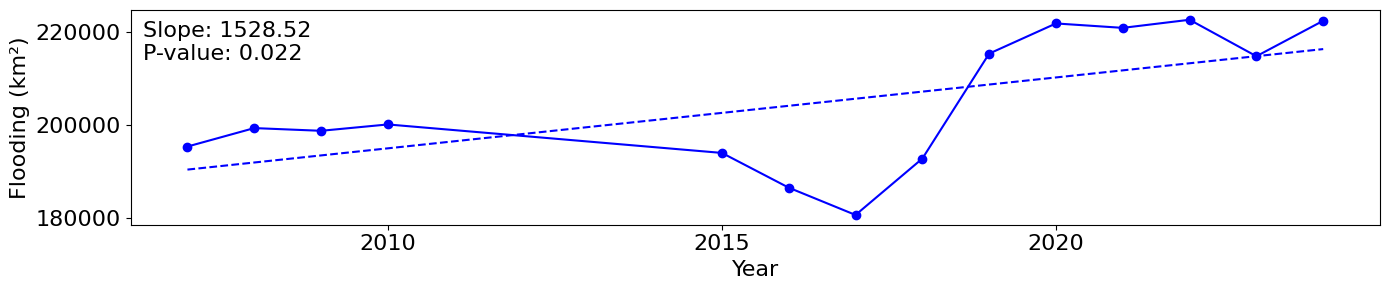

In [48]:
### plot change in swamp forest extent

# Create a single figure and axis
fig, ax = plt.subplots(figsize=(14, 3))

# Define a function to add a linear trend line and annotate slope + p-value
def add_trend_line(x, y, ax, color='k'):
    valid_data = pd.DataFrame({'x': x, 'y': y}).dropna()
    x_valid = valid_data['x']
    y_valid = valid_data['y']

    if len(x_valid) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(x_valid, y_valid)
        trend_line = slope * x_valid + intercept
        ax.plot(x_valid, trend_line, color=color, linestyle='--')

        ax.text(0.01, 0.95,
                f"Slope: {slope:.2f}\nP-value: {p_value:.3f}",
                transform=ax.transAxes,
                fontsize=16,
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Plot flooded_area_km2_classified
ax.plot(area_trends_ci['year'], area_trends_ci['flooded_area_km2_classified'], color='b', marker='o', linestyle='-')
ax.set_ylabel('Flooding (km²)', fontsize=16)
add_trend_line(area_trends_ci['year'], area_trends_ci['flooded_area_km2_classified'], ax, color='b')

# Set x-axis label and ticks
ax.set_xlabel('Year', fontsize=16)
ax.set_xticks([2010, 2015, 2020])
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
ax.tick_params(axis='both', labelsize=16)

# Adjust layout
plt.tight_layout()
plt.show()


In [74]:
### load subbasins data
subbasins_trends = pd.read_csv("/content/drive/MyDrive/Annual_Swamp_forest_extents_by_subbasin.csv")

# convert area to km2 and select only required columns
subbasins_trends["flooded_area_km2_classified"] = subbasins_trends["sum"] / 1e6
subbasins_trends = subbasins_trends[["year", "HYBAS_ID", "flooded_area_km2_classified"]]

In [76]:
subbasins_trends

,year,HYBAS_ID,flooded_area_km2_classified
0,2007,1041213630,3314.46
1,2007,1041213640,27548.45
2,2007,1041174950,37449.03
3,2007,1041174960,3578.42
4,2007,1041156960,94292.77
...,...,...,...
121,2024,1041156960,103006.72
122,2024,1041156950,31873.82
123,2024,1041259940,2.24
124,2024,1041259950,0.02


In [75]:
# Apply slope calculation with CIs per subbasin
results = subbasins_trends.groupby('HYBAS_ID').apply(compute_slope_ci).reset_index()
# View results
print(results)

     HYBAS_ID  slope  ci_lower  ci_upper  p_value
0  1040020040   1.69     -4.58      7.95     0.57
1  1041156950 178.88     10.41    347.36     0.04
2  1041156960 645.57   -214.58   1505.72     0.13
3  1041174950 420.21    294.54    545.87     0.00
4  1041174960  27.74     14.53     40.95     0.00
5  1041213630  43.62     18.96     68.28     0.00
6  1041213640 210.85     25.66    396.04     0.03
7  1041259940  -0.03     -0.11      0.05     0.47
8  1041259950   0.00      0.00      0.00     0.03


## Forest productivity trends

In [51]:
### EVI pixel-wise significant trends
with rasterio.open("/content/drive/MyDrive/EVI_2007_2024_Stack.tif") as src:
    stack = src.read()  # shape: (years, rows, cols)
    profile = src.profile
rows, cols = stack.shape[1], stack.shape[2]
years = np.arange(2007, 2007 + stack.shape[0])  # adjust start year
slope_arr = np.full((rows, cols), np.nan)
pval_arr = np.full((rows, cols), np.nan)
for i in range(rows):
    for j in range(cols):
        y = stack[:, i, j]
        if np.any(np.isnan(y)) or np.all(y == 0):  # skip missing or empty pixels
            continue
        slope, _, _, p_value, _ = linregress(years, y)
        slope_arr[i, j] = slope
        pval_arr[i, j] = p_value

In [ ]:
### plot slopes
plt.figure(figsize=(10, 6))
plt.imshow(np.flipud(slope_arr), cmap='RdYlGn', vmin=-0.01, vmax=0.01)
plt.title("EVI Trend (Slope per Pixel)")
plt.colorbar(label='Slope')
plt.axis('off')
plt.show()

In [ ]:
### print percentage of pixels with significant trends

# Flatten arrays to make pixel-wise calculations easier
slope_flat = slope_arr.flatten()
pval_flat = pval_arr.flatten()
# Mask out nan or 0 pixels
valid_mask = ~np.isnan(slope_flat) & (slope_flat != 0)
# Apply valid mask
slope_flat = slope_flat[valid_mask]
pval_flat = pval_flat[valid_mask]
# Total valid pixels
total = len(slope_flat)
# Conditions
increasing = slope_flat > 0
decreasing = slope_flat < 0
significant = pval_flat < 0.05
# Calculate each category
inc_total = np.sum(increasing)
dec_total = np.sum(decreasing)
inc_sig = np.sum(increasing & significant)
dec_sig = np.sum(decreasing & significant)
# Percentages
print(f"Total valid pixels: {total}")
print(f"Increasing trend: {inc_total} pixels ({(inc_total / total) * 100:.2f}%)")
print(f"Significant increasing trend: {inc_sig} pixels ({(inc_sig / total) * 100:.2f}%)")
print(f"Decreasing trend: {dec_total} pixels ({(dec_total / total) * 100:.2f}%)")
print(f"Significant decreasing trend: {dec_sig} pixels ({(dec_sig / total) * 100:.2f}%)")

In [56]:
### paired t test on swamp and dry forests evi
evi_trends = pd.read_csv("/content/drive/MyDrive/Summary_stats_SwampForestExtents_and_EVI_2007_2024.csv")

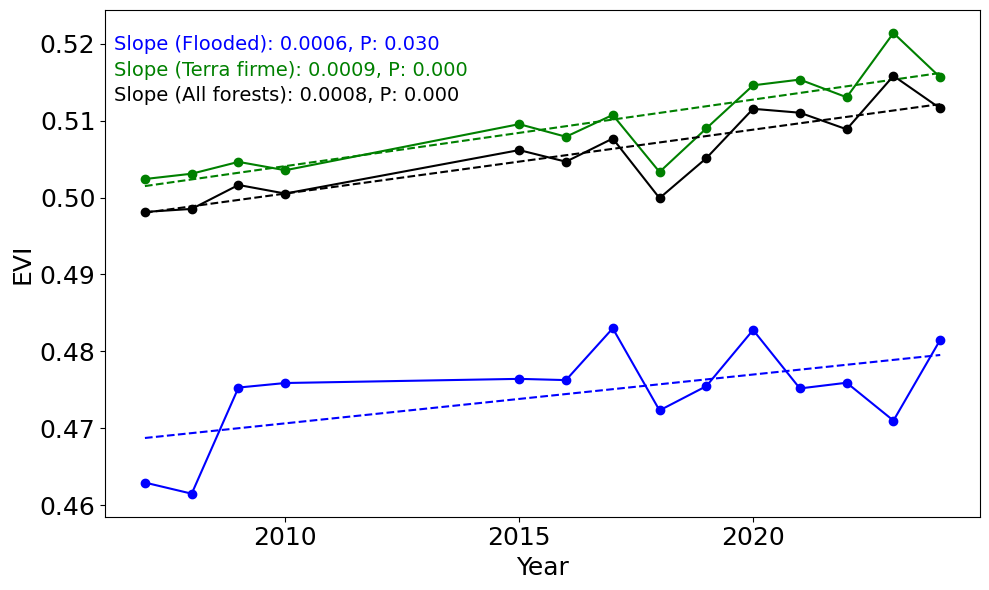

In [57]:
### Congo Basin timeseries trends for EVI in swamp forests, dry forests and all forests

# Create a single figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Updated function to add trend line and label it with custom name and matching color
def add_trend_line(x, y, ax, color='k', label_pos=0.95, series_name=''):
    valid_data = pd.DataFrame({'x': x, 'y': y}).dropna()
    x_valid = valid_data['x']
    y_valid = valid_data['y']

    if len(x_valid) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(x_valid, y_valid)
        trend_line = slope * x_valid + intercept
        ax.plot(x_valid, trend_line, color=color, linestyle='--')
        ax.text(0.01, label_pos,
                f"Slope ({series_name}): {slope:.4f}, P: {p_value:.3f}",
                color=color,  # <- Match text color to trend line
                transform=ax.transAxes,
                fontsize=14,
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

# Plot function with added series_name
def plot_mean_min_max(ax, year, mean_col, color, label, trend_y, series_name):
    ax.plot(year, evi_trends[mean_col], color=color, linestyle='-', marker='o', label=f'{label} (mean)')
    add_trend_line(year, evi_trends[mean_col], ax, color=color, label_pos=trend_y, series_name=series_name)

# Plot all three with custom names
plot_mean_min_max(ax, evi_trends['year'],
                  'EVI_mean_flooded_forests',
                  'blue', 'Flooded forest EVI', trend_y=0.95, series_name='Flooded')

plot_mean_min_max(ax, evi_trends['year'],
                  'EVI_mean_non_flooded_forests',
                  'green', 'Terra firme EVI', trend_y=0.90, series_name='Terra firme')

plot_mean_min_max(ax, evi_trends['year'],
                  'EVI_mean_forests',
                  'black', 'All forests EVI', trend_y=0.85, series_name='All forests')

# Axis labels and formatting
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('EVI', fontsize=18)
ax.set_xticks([2010, 2015, 2020])
ax.tick_params(axis='both', labelsize=18)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.tight_layout()
plt.show()

In [ ]:
# Run paired t-test
t_stat, p_val = ttest_rel(evi_trends["EVI_mean_flooded_forests"], evi_trends["EVI_mean_non_flooded_forests"])
print(f"Paired t-test:\n  t-statistic = {t_stat:.4f}, p-value = {p_val:.4f}")
# Non-parametric alternative
w_stat, p_wilcox = wilcoxon(evi_trends["EVI_mean_flooded_forests"], evi_trends["EVI_mean_non_flooded_forests"])
print(f"Wilcoxon signed-rank test:\n  statistic = {w_stat:.4f}, p-value = {p_wilcox:.4f}")

## GHG emissions

In [59]:
### Load data

# Flood depths and WTLs
df = pd.read_csv("/content/drive/MyDrive/Summary_stats_Flood_depths_and_WTLs_areas_2007_2024.csv")
# GHG fluxes by WTL
ghg = pd.read_csv("/content/drive/MyDrive/Zou_2022_GHG_fluxes_by_WTL_tropics.csv")

In [60]:
# Identify columns that are in per hectare per year units
ha_yr_cols = [col for col in ghg.columns if '_ha_yr' in col]
# Create a new DataFrame by copying the original
ghg_km2 = ghg.copy()
# Convert ha-based values to km² by multiplying by 100
ghg_km2[ha_yr_cols] = ghg_km2[ha_yr_cols] * 100

# Map WTL values to flood depth area column names
wtl_to_area_col = {
    -3: 'area_km2_flood_depth_lt_minus70cm',
    -2: 'area_km2_flood_depth_minus70_minus50cm',
    -1: 'area_km2_flood_depth_minus50_minus30cm',
     0: 'area_km2_flood_depth_minus30_minus5cm',
     1: 'area_km2_flood_depth_minus5_40cm',
     2: 'area_km2_flood_depth_gt_40cm'
}
# Select only relevant WTL rows from ghg_km2
ghg_selected = ghg_km2[ghg_km2['WTL'].isin(wtl_to_area_col.keys())]
# Create a list to store results
results = []
# Iterate over each row (year) in df
for _, row in df.iterrows():
    year = row['year']
    total_CO2 = total_CO2_lower = total_CO2_upper = 0
    total_CH4 = total_CH4_lower = total_CH4_upper = 0
    total_N2O = total_N2O_lower = total_N2O_upper = 0
    total_GHGs = total_GHGs_lower = total_GHGs_upper = 0
    # For each WTL class, multiply emissions by area
    for wtl, area_col in wtl_to_area_col.items():
        area = row[area_col]  # in km²
        emissions = ghg_selected[ghg_selected['WTL'] == wtl].iloc[0]
        total_CO2     += area * emissions['NEE_CO2_T_ha_yr']           # already per km²
        total_CO2_lower += area * emissions['Lower_95_CI_CO2_T_ha_yr']
        total_CO2_upper += area * emissions['Upper_95_CI_CO2_T_ha_yr']
        total_CH4     += area * emissions['CH4_KG_ha_yr']
        total_CH4_lower += area * emissions['Lower_95_CI_CH4_KG_ha_yr']
        total_CH4_upper += area * emissions['Upper_95_CI_CH4_KG_ha_yr']
        total_N2O     += area * emissions['N20_KG_ha_yr']
        total_N2O_lower += area * emissions['Lower_95_CI_N20_KG_ha_yr']
        total_N2O_upper += area * emissions['Upper_95_CI_N20_KG_ha_yr']
        total_GHGs     += area * emissions['SUM_GHGs_T_CO2eq_ha_yr']
        total_GHGs_lower += area * emissions['Lower_95_CI_SUM_GHGs_T_CO2eq_ha_yr']
        total_GHGs_upper += area * emissions['Upper_95_CI_SUM_GHGs_T_CO2eq_ha_yr']
    results.append({
        'year': year,
        'Total_CO2_T': total_CO2,
        'Lower_95_CI_CO2_T': total_CO2_lower,
        'Upper_95_CI_CO2_T': total_CO2_upper,
        'Total_CH4_KG': total_CH4,
        'Lower_95_CI_CH4_KG': total_CH4_lower,
        'Upper_95_CI_CH4_KG': total_CH4_upper,
        'Total_N2O_KG': total_N2O,
        'Lower_95_CI_N2O_KG': total_N2O_lower,
        'Upper_95_CI_N2O_KG': total_N2O_upper,
        'Total_GHGs_T_CO2eq': total_GHGs,
        'Lower_95_CI_GHGs_T_CO2eq': total_GHGs_lower,
        'Upper_95_CI_GHGs_T_CO2eq': total_GHGs_upper
    })
# Convert the results to a DataFrame
emissions_df = pd.DataFrame(results)

In [61]:
# Convert CH4 and N2O from kg to metric tons (1 tonne = 1000 kg)
emissions_df['Total_CH4_T'] = emissions_df['Total_CH4_KG'] / 1000
emissions_df['Total_N2O_T'] = emissions_df['Total_N2O_KG'] / 1000
# Convert CH4 and N2O confidence intervals from kg to tonnes
emissions_df['Lower_95_CI_CH4_T'] = emissions_df['Lower_95_CI_CH4_KG'] / 1000
emissions_df['Upper_95_CI_CH4_T'] = emissions_df['Upper_95_CI_CH4_KG'] / 1000
emissions_df['Lower_95_CI_N2O_T'] = emissions_df['Lower_95_CI_N2O_KG'] / 1000
emissions_df['Upper_95_CI_N2O_T'] = emissions_df['Upper_95_CI_N2O_KG'] / 1000

In [ ]:
### remove kg columns to display
emissions_df = emissions_df.loc[:, ~emissions_df.columns.str.contains('KG')]

pd.set_option('display.float_format', '{:.2f}'.format)
emissions_df

In [ ]:
# Combine WTLs area with GHG fluxes per km2

# Prepare individual data series
series_list = [
    ("CO₂", emissions_df['year'], emissions_df['Total_CO2_T'] / 1e8),
    ("CH₄", emissions_df['year'], emissions_df['Total_CH4_T'] / 1e7),
    ("N₂O", emissions_df['year'], emissions_df['Total_N2O_T'] / 1e6),
    ("Total GHGs (CO₂eq)", emissions_df['year'], emissions_df['Total_GHGs_T_CO2eq'] / 1e8)
]
# Function to compute stats
def print_trend_stats(label, x, y):
    valid_data = pd.DataFrame({'x': x, 'y': y}).dropna()
    x = valid_data['x']
    y = valid_data['y']
    if len(x) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        df = len(x) - 2
        t_crit = t.ppf(0.975, df)
        ci_lower = slope - t_crit * std_err
        ci_upper = slope + t_crit * std_err
        print(f"{label} Trend:")
        print(f"  Slope: {slope:.5f}")
        print(f"  95% CI: ({ci_lower:.5f}, {ci_upper:.5f})")
        print(f"  P-value: {p_value:.5f}\n")
    else:
        print(f"{label} Trend: Insufficient data\n")
# Apply to each series
for label, x, y in series_list:
    print_trend_stats(label, x, y)

In [ ]:
# plot GHG trends

# Prepare individual data series
years = emissions_df['year']
co2 = emissions_df['Total_CO2_T']
ch4 = emissions_df['Total_CH4_T']
n2o = emissions_df['Total_N2O_T']
ghgs = emissions_df['Total_GHGs_T_CO2eq']

# Create a figure with 4 subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Function to add linear trend line and annotate slope & p-value
def add_trend_line(x, y, ax, color='k', x_pos=0.01, y_pos=0.95):
    valid_data = pd.DataFrame({'x': x, 'y': y}).dropna()
    x_valid = valid_data['x']
    y_valid = valid_data['y']

    if len(x_valid) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(x_valid, y_valid)
        trend_line = slope * x_valid + intercept
        ax.plot(x_valid, trend_line, color=color, linestyle='--')

        # Add annotation
        ax.text(x_pos, y_pos,
                f"Slope: {slope:.3f}\nP-value: {p_value:.3f}",
                transform=ax.transAxes,
                fontsize=16,
                verticalalignment='bottom' if y_pos < 0.5 else 'top',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# CO2 – bottom left, scaled to 1e8
axes[0].plot(years, co2 / 1e8, color='forestgreen', marker='o', linestyle='-')
axes[0].set_ylabel('CO₂ (100 million tonnes)', fontsize=16)
add_trend_line(years, co2 / 1e8, axes[0], color='forestgreen', x_pos=0.01, y_pos=0.05)
axes[0].ticklabel_format(style='plain', axis='y')  # Disable scientific notation

# CH4 – top left, scaled to 1e7
axes[1].plot(years, ch4 / 1e7, color='darkorange', marker='o', linestyle='-')
axes[1].set_ylabel('CH₄ (10 million tonnes)', fontsize=16)
add_trend_line(years, ch4 / 1e7, axes[1], color='darkorange', x_pos=0.01, y_pos=0.95)
axes[1].ticklabel_format(style='plain', axis='y')

# N2O – bottom left, scale as needed
axes[2].plot(years, n2o / 1e6, color='royalblue', marker='o', linestyle='-')
axes[2].set_ylabel('N₂O (million tonnes)', fontsize=16)
add_trend_line(years, n2o / 1e6, axes[2], color='royalblue', x_pos=0.01, y_pos=0.05)
axes[2].ticklabel_format(style='plain', axis='y')

# Total GHGs – bottom left, scaled to 1e8
axes[3].plot(years, ghgs / 1e8, color='black', marker='o', linestyle='-')
axes[3].set_ylabel('CO₂eq (100 million tonnes)', fontsize=16)
add_trend_line(years, ghgs / 1e8, axes[3], color='black', x_pos=0.01, y_pos=0.05)
axes[3].ticklabel_format(style='plain', axis='y')

# X-axis formatting
axes[3].set_xlabel('Year', fontsize=16)
axes[3].set_xticks([2010, 2015, 2020])

for ax in axes:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
    ax.tick_params(axis='both', labelsize=14)

plt.tight_layout()

fig.align_ylabels(axes)

plt.show()
